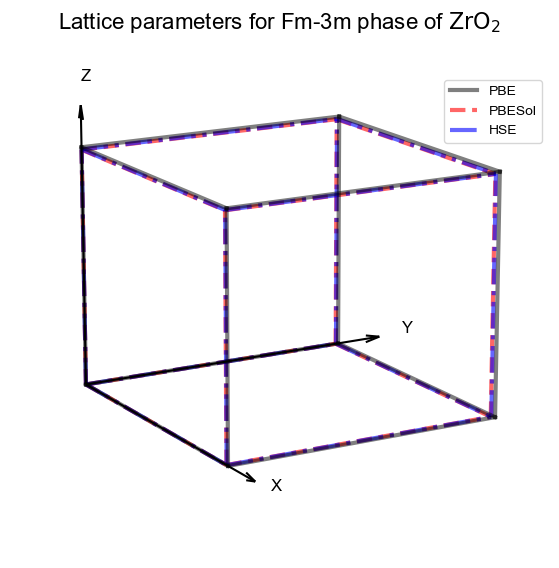

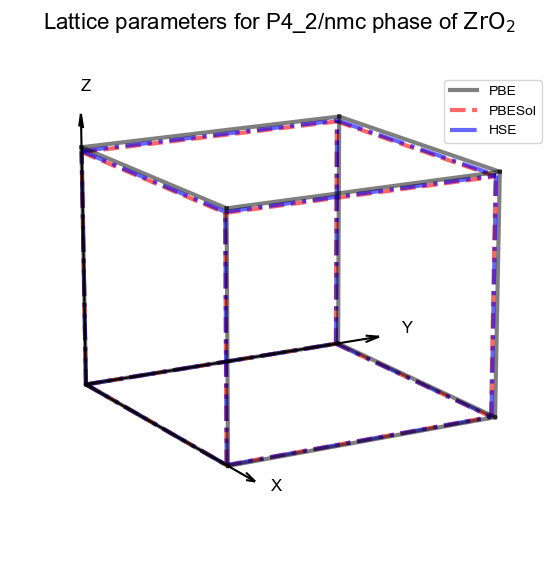

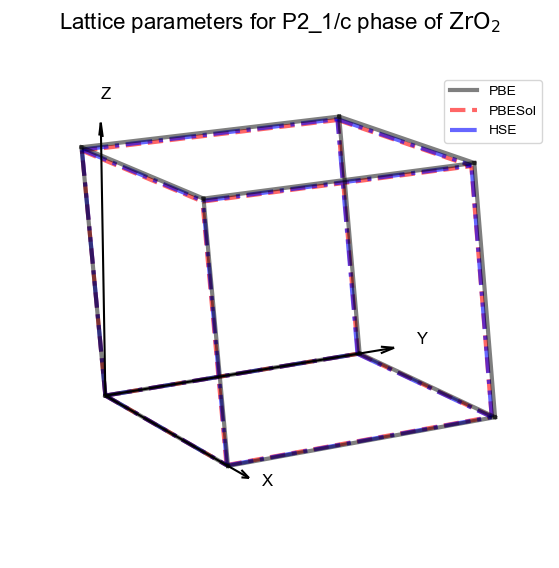

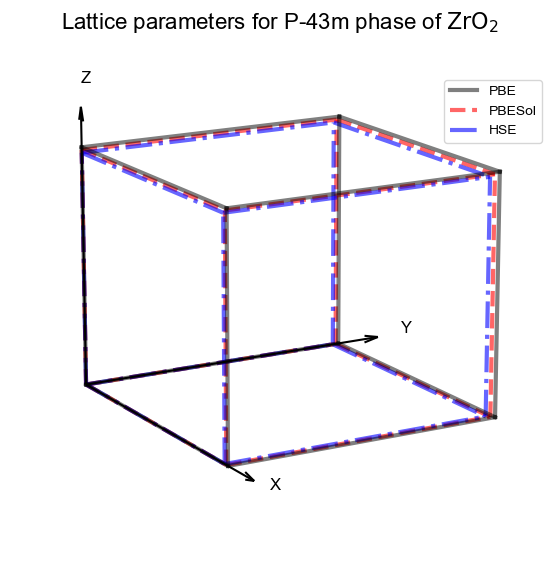

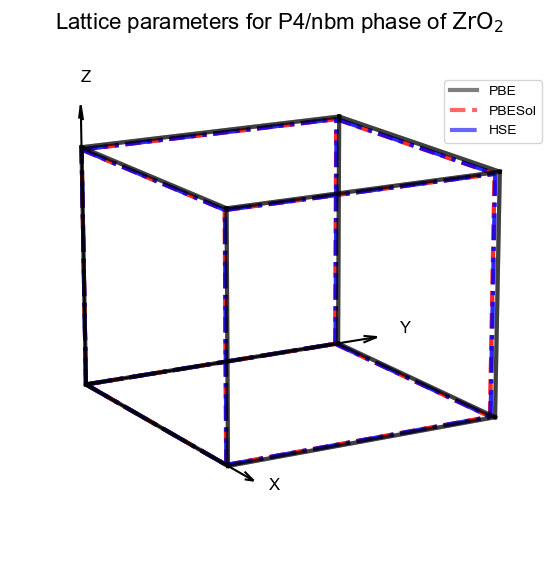

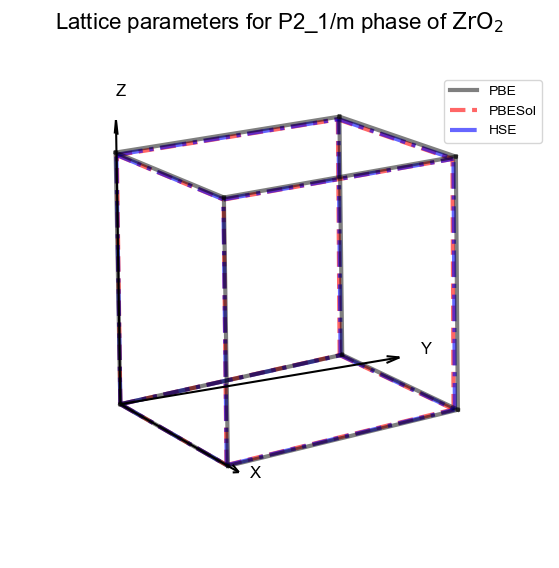

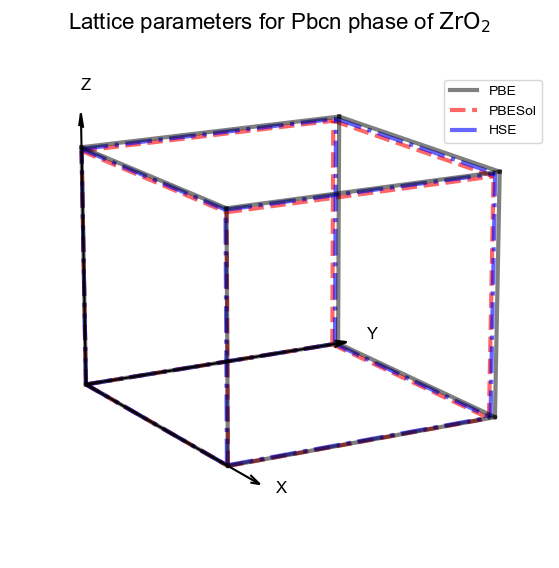

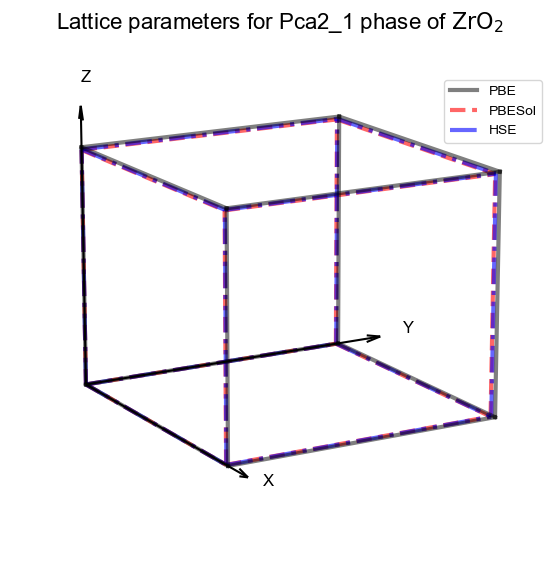

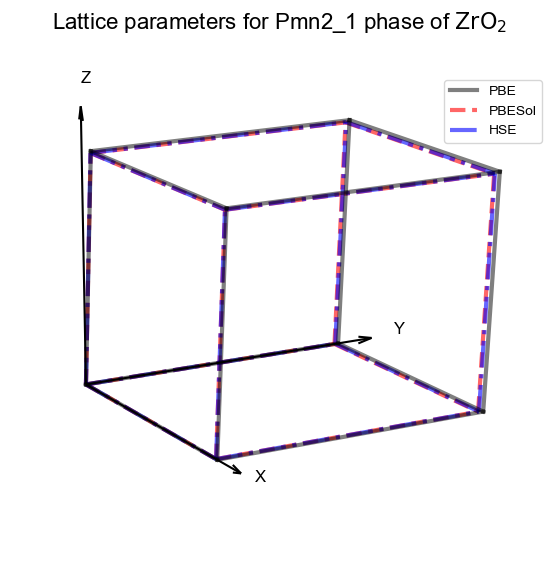

In [15]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import re

matplotlib.rcParams['font.family'] = 'Arial'

def sanitize_filename(filename):
    return re.sub(r'[\/:*?"<>|]', '__', filename)

# Function to plot the cubic structure for each phase
def plot_structure(df):
    space_groups = df['Space Group'].unique()
    
    # Colors for different functionals and line styles
    functional_colors = {'PBE': 'black', 'PBESol': 'red', 'HSE': 'blue'}
    line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '-.'}
    functional_alpha = {'PBE': 0.5, 'PBESol': 0.6, 'HSE': 0.6}
    
    # # Colors for different functionals and line styles
    # functional_colors = {'PBE': '#2ca02c', 'PBESol': '#ff7f0e', 'HSE': '#1f77b4'}
    # line_styles = {'PBE': '-', 'PBESol': '--', 'HSE': '-.'}
    # functional_alpha = {'PBE': 0.5, 'PBESol': 0.5, 'HSE': 0.5}

    # # Add markers for clarity
    # markers = {'PBE': 'o', 'PBESol': '^', 'HSE': 's'}


    # Loop over each space group
    for space_group in space_groups:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')  # No frame_on for 3D axes
        
        # Remove the frame (border) by setting the spines to invisible
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Filter data by space group
        space_group_data = df[df['Space Group'] == space_group]
        
        # Loop through the data for each functional
        for functional in ['PBESol', 'HSE','PBE']:
            # Get the columns corresponding to the functional
            a_col = f"{functional} a"
            b_col = f"{functional} b"
            c_col = f"{functional} c"
            alpha_col = f"{functional} alpha"
            beta_col = f"{functional} beta"
            gamma_col = f"{functional} gamma"
            
            for _, row in space_group_data.iterrows():
                # Extract lattice constants and angles
                a, b, c = row[a_col], row[b_col], row[c_col]
                alpha, beta, gamma = row[alpha_col], row[beta_col], row[gamma_col]
                
                # Check if any value is NaN
                if any(np.isnan([a, b, c, alpha, beta, gamma])):
                    continue
                
                # Convert angles from degrees to radians
                alpha_rad = np.radians(alpha)
                beta_rad = np.radians(beta)
                gamma_rad = np.radians(gamma)
                
                # Define the transformation matrix for the lattice
                # Using the full formula for non-orthogonal lattice
                A = np.array([
                    [a, 0, 0],
                    [b * np.cos(gamma_rad), b * np.sin(gamma_rad), 0],
                    [c * np.cos(beta_rad), 
                     c * (np.cos(alpha_rad) - np.cos(beta_rad) * np.cos(gamma_rad)) / np.sin(gamma_rad), 
                     c * np.sqrt(1 - np.cos(beta_rad)**2 - (np.cos(alpha_rad) - np.cos(beta_rad) * np.cos(gamma_rad))**2 / np.sin(gamma_rad)**2)]
                ])
                
                # Generate the 8 corners of the unit cell based on the lattice matrix
                corners = []
                for i in range(2):
                    for j in range(2):
                        for k in range(2):
                            # Use the lattice matrix A to generate the points
                            point = i * A[0] + j * A[1] + k * A[2]
                            corners.append(point)
                
                corners = np.array(corners)


                lines = [
                    [corners[0], corners[1]],  # (0,0,0) -> (a,0,0)
                    [corners[0], corners[2]],  # (0,0,0) -> (0,b,0)
                    [corners[0], corners[4]],  # (0,0,0) -> (0,0,c)
                    [corners[1], corners[3]],  # (a,0,0) -> (a,b,0)
                    [corners[1], corners[5]],  # (a,0,0) -> (a,0,c)
                    [corners[2], corners[3]],  # (0,b,0) -> (a,b,0)
                    [corners[2], corners[6]],  # (0,b,0) -> (0,b,c)
                    [corners[4], corners[5]],  # (0,0,c) -> (a,0,c)
                    [corners[4], corners[6]],  # (0,0,c) -> (0,b,c)
                    [corners[5], corners[7]],  # (a,0,c) -> (a,b,c)
                    [corners[6], corners[7]],  # (0,b,c) -> (a,b,c)
                    [corners[3], corners[7]]   # (a,b,0) -> (a,b,c)
                ]

                for line in lines:
                    ax.plot([line[0][0], line[1][0]], 
                            [line[0][1], line[1][1]], 
                            [line[0][2], line[1][2]], 
                            color=functional_colors[functional], 
                            linestyle=line_styles[functional], 
                            lw=3,
                            alpha=functional_alpha[functional])

                    # midpoint = (line[0] + line[1]) / 2
                    # ax.scatter(midpoint[0], midpoint[1], midpoint[2], 
                    #            color=functional_colors[functional], 
                    #            marker=markers[functional], 
                    #            s=100, alpha=0.7)


        # Set the title for the plot
        ax.set_title(f"Lattice parameters for {space_group} phase of $\\text{{ZrO}}_2$", fontsize=16, y=1.05)#pad=-80
        
        # Draw orthogonal arrows indicating the positive direction of the axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 1, 0, color='black', length=6, arrow_length_ratio=0.05)
        ax.quiver(0, 0, 0, 0, 0, 1, color='black', length=6, arrow_length_ratio=0.05)

        # Label the axes
        ax.text(6.5, 0, 0, 'X', color='black', fontsize=12)
        ax.text(0, 6.5, 0, 'Y', color='black', fontsize=12)
        ax.text(0, 0, 6.5, 'Z', color='black', fontsize=12)
        
        # Set the viewing angle
        ax.view_init(elev=15, azim=-30)
        
        # Remove the grid, axis labels, and ticks
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        # Manually create a legend with matching colors and line styles
        handles = []
        for functional, color in functional_colors.items():
            line = plt.Line2D([0], [0], color=color, linestyle=line_styles[functional], alpha=functional_alpha[functional], lw=3)
            handles.append(line)
        
        # Show the plot with the updated legend
        ax.legend(handles, ['PBE', 'PBESol', 'HSE'], loc='upper right', bbox_to_anchor=(1, 0.9))

        # Remove the axis frame
        ax.set_axis_off()

        # Save the plot as a PNG file
        filename=f"structure_{space_group}"
        filename=sanitize_filename(filename)
        plt.savefig(f"{filename}_edit.png", dpi=300, bbox_inches='tight')
        
        # Show the plot
        plt.show()


# Read the CSV file
df = pd.read_csv('structure_data_grouped_.csv')

# Plot the structures
plot_structure(df)
